# TPS 12/21 - Comparison of Classifiers

In this notebook, we test out several scikit-learn compatible classifiers. For the most part, we do not do any model tuning and leave default settings.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 5
TEST_SIZE = 2500000

In [2]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Save data as .feather format
train = pd.read_feather('../data/train.feather')

# Drop Label = 5
train = train[train.Cover_Type != 5]

In [4]:
# Split synthetic data
train, test = train_test_split(train, test_size = TEST_SIZE, random_state = RANDOM_SEED)
features = [x for x in train.columns if x not in ['Id','Cover_Type']]

gc.collect()

# Label Encoding
new_encoder = LabelEncoder()
train["Cover_Type"] = new_encoder.fit_transform(train["Cover_Type"])
test["Cover_Type"] = new_encoder.transform(test["Cover_Type"])

# Data structures for summary scores
new_rows = list()

print(f'Synthetic Train Size: {train.shape[0]} rows, {train.shape[1]} cols')
print(f'Synthetic Test Size: {test.shape[0]} rows, {test.shape[1]} cols\n')

Synthetic Train Size: 1499999 rows, 56 cols
Synthetic Test Size: 2500000 rows, 56 cols



# Scoring Function

In [5]:
# Scoring/Training Baseline Function
def score_newdata(sklearn_model):
    
    print('Data: TPS 12/21 (Synthetic)')
    
    # Store the holdout predictions
    oof_preds = np.zeros((train.shape[0],))
    test_preds = np.zeros((test.shape[0], len(train.Cover_Type.value_counts())))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    print('')
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(train, train['Cover_Type'])):
        
        # Training and Validation Sets
        X_train = train[features].iloc[train_idx]
        X_valid = train[features].iloc[valid_idx]
        X_test = test[features]
        
        # Training and Target Labels
        y_train = train['Cover_Type'].iloc[train_idx]
        y_valid = train['Cover_Type'].iloc[valid_idx]
        y_test = test['Cover_Type']
        
        gc.collect()
        
        # Create model
        model = clone(sklearn_model)
            
        start = time.time()

        model.fit(X_train, y_train)
        
        end = time.time()
        
        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        oof_preds[valid_idx] = valid_preds
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        
        time.sleep(0.5)
        
    test_preds = np.argmax(test_preds, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('\nHoldout Accuracy:', holdout)
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    fig, ax = plt.subplots(figsize = (8,6))
    cm = confusion_matrix(y_test, test_preds, normalize = 'true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax)
    plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=14)
    plt.ylabel("Actual Labels", fontsize=14)
    plt.show()
    
    return scores.mean(), oof_preds, holdout


# Logistic Regression

In [6]:
# Logistic Regression
logit_pipeline = make_pipeline(
    RobustScaler(),
    LogisticRegression(
        solver = 'saga',
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.91735 in 410.96s.
Fold 1 Accuracy: 0.91744 in 457.29s.
Fold 2 Accuracy: 0.91699 in 277.54s.
Fold 3 Accuracy: 0.91693 in 271.0s.
Fold 4 Accuracy: 0.91723 in 275.86s.

Average CV Accuracy: 0.91719
Worst CV Accuracy: 0.91693

Holdout Accuracy: 0.9169852
Training Time: 1692.64s



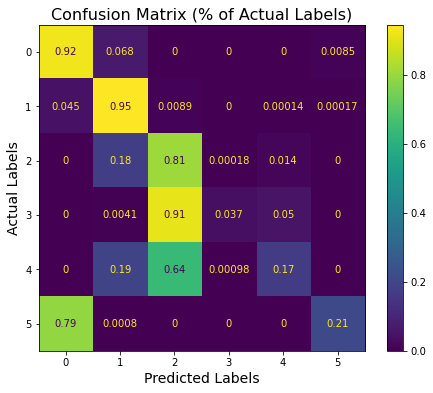

In [7]:
cv_score, oof_preds, holdout = score_newdata(logit_pipeline)

new_rows.append((
    'Logistic_Regression', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# Ridge Regression

In [8]:
# Class extending Ridge Regression
class ExtendedRidgeClassifier(RidgeClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))
    
# Ridge Regression
ridge_pipeline = make_pipeline(
    RobustScaler(),
    ExtendedRidgeClassifier(
        solver = 'saga',
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.89656 in 77.49s.
Fold 1 Accuracy: 0.89687 in 92.31s.
Fold 2 Accuracy: 0.89551 in 74.87s.
Fold 3 Accuracy: 0.89555 in 61.38s.
Fold 4 Accuracy: 0.8957 in 61.37s.

Average CV Accuracy: 0.89604
Worst CV Accuracy: 0.89551

Holdout Accuracy: 0.896366
Training Time: 367.42s



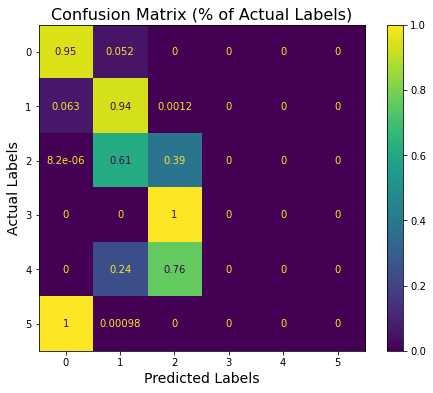

In [9]:
cv_score, oof_preds, holdout = score_newdata(ridge_pipeline)

new_rows.append((
    'Ridge_Regression', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# Linear Discriminant Analysis

In [10]:
# Linear Discriminant Analysis
lda_pipeline = make_pipeline(
    RobustScaler(),
    LinearDiscriminantAnalysis(),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.87815 in 11.76s.
Fold 1 Accuracy: 0.87859 in 11.01s.
Fold 2 Accuracy: 0.87812 in 11.03s.
Fold 3 Accuracy: 0.87864 in 10.88s.
Fold 4 Accuracy: 0.87777 in 11.0s.

Average CV Accuracy: 0.87825
Worst CV Accuracy: 0.87777

Holdout Accuracy: 0.878394
Training Time: 55.68s



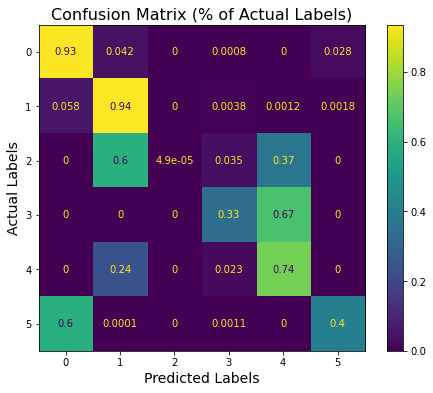

In [11]:
cv_score, oof_preds, holdout = score_newdata(lda_pipeline)

new_rows.append((
    'Linear_Discriminant', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# SGDClassifier

In [12]:
# Extended SGDClassifier
class ExtendedSGDClassifier(SGDClassifier):
    def predict_proba(self, X):
        return softmax(self.decision_function(X))

# SGDClassifier
sgd_pipeline = make_pipeline(
    RobustScaler(), 
    ExtendedSGDClassifier(
        learning_rate = 'optimal', 
        penalty = 'l2', 
        random_state = RANDOM_SEED
    )
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.90078 in 13.45s.
Fold 1 Accuracy: 0.9011 in 13.6s.
Fold 2 Accuracy: 0.9 in 13.36s.
Fold 3 Accuracy: 0.90065 in 13.39s.
Fold 4 Accuracy: 0.90093 in 13.28s.

Average CV Accuracy: 0.90069
Worst CV Accuracy: 0.9

Holdout Accuracy: 0.90099
Training Time: 67.08s



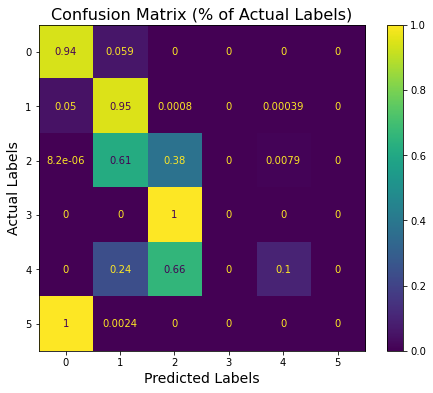

In [13]:
cv_score, oof_preds, holdout = score_newdata(sgd_pipeline)

new_rows.append((
    'SGDClassifier', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# Naive Bayes

In [14]:
# Naive Bayes Classifier
nb_pipeline = make_pipeline(
    RobustScaler(),
    MinMaxScaler(),
    MultinomialNB(),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.59167 in 4.65s.
Fold 1 Accuracy: 0.5917 in 4.58s.
Fold 2 Accuracy: 0.59219 in 4.57s.
Fold 3 Accuracy: 0.59002 in 4.51s.
Fold 4 Accuracy: 0.5925 in 4.61s.

Average CV Accuracy: 0.59162
Worst CV Accuracy: 0.59002

Holdout Accuracy: 0.5916252
Training Time: 22.94s



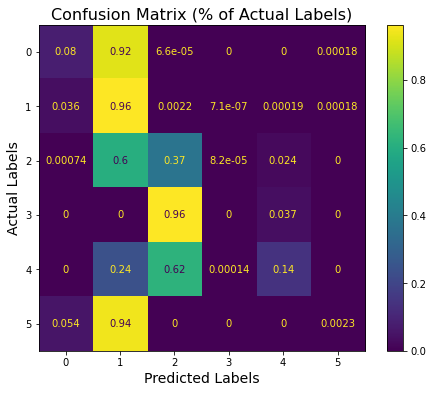

In [15]:
cv_score, oof_preds, holdout = score_newdata(nb_pipeline)

new_rows.append((
    'Naive_Bayes', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# Multilayer Perceptron

In [16]:
# Multi-layer Perceptron Classifier
mlp_pipeline = make_pipeline(
    RobustScaler(),
    MLPClassifier(
        hidden_layer_sizes=(len(features), len(features)//2),
        batch_size = 512, 
        early_stopping = True,
        validation_fraction = 0.2,
        n_iter_no_change = 5,
        random_state = RANDOM_SEED
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95808 in 130.12s.
Fold 1 Accuracy: 0.957 in 90.35s.
Fold 2 Accuracy: 0.95805 in 107.01s.
Fold 3 Accuracy: 0.95778 in 107.67s.
Fold 4 Accuracy: 0.95789 in 88.69s.

Average CV Accuracy: 0.95776
Worst CV Accuracy: 0.957

Holdout Accuracy: 0.959738
Training Time: 523.84s



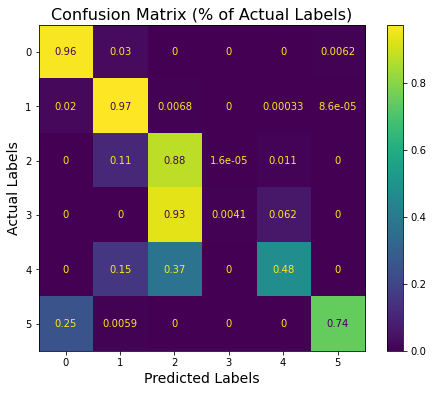

In [17]:
cv_score, oof_preds, holdout = score_newdata(mlp_pipeline)

new_rows.append((
    'Multilayer_Perceptron', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# XGBoost

In [18]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95896 in 39.33s.
Fold 1 Accuracy: 0.95779 in 38.98s.
Fold 2 Accuracy: 0.95879 in 39.42s.
Fold 3 Accuracy: 0.958 in 38.97s.
Fold 4 Accuracy: 0.95858 in 39.21s.

Average CV Accuracy: 0.95842
Worst CV Accuracy: 0.95779

Holdout Accuracy: 0.9590212
Training Time: 195.92s



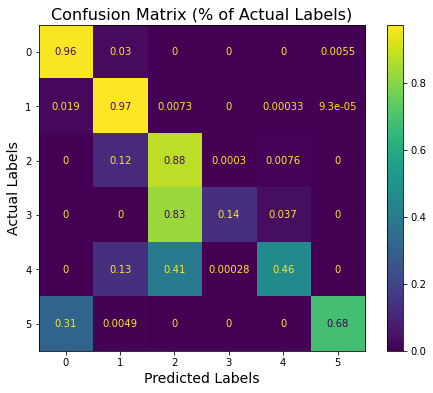

In [19]:
cv_score, oof_preds, holdout = score_newdata(xgb_pipeline)

new_rows.append((
    'XGBoost', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# LightGBM

In [20]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.94371 in 25.59s.
Fold 1 Accuracy: 0.94881 in 27.25s.
Fold 2 Accuracy: 0.95298 in 28.11s.
Fold 3 Accuracy: 0.94415 in 28.24s.
Fold 4 Accuracy: 0.94925 in 28.69s.

Average CV Accuracy: 0.94778
Worst CV Accuracy: 0.94371

Holdout Accuracy: 0.9550832
Training Time: 137.87s



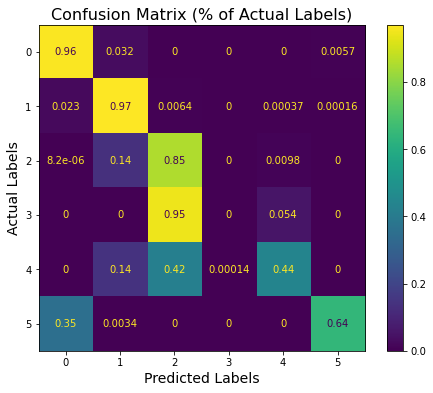

In [21]:
cv_score, oof_preds, holdout = score_newdata(lgbm_pipeline)

new_rows.append((
    'LightGBM', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# CatBoost

In [22]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        boosting_type = 'Plain',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

Data: TPS 12/21 (Synthetic)

Fold 0 Accuracy: 0.95948 in 379.43s.
Fold 1 Accuracy: 0.95843 in 380.24s.
Fold 2 Accuracy: 0.95908 in 380.79s.
Fold 3 Accuracy: 0.95864 in 396.63s.
Fold 4 Accuracy: 0.95881 in 400.31s.

Average CV Accuracy: 0.95889
Worst CV Accuracy: 0.95843

Holdout Accuracy: 0.9592668
Training Time: 1937.4s



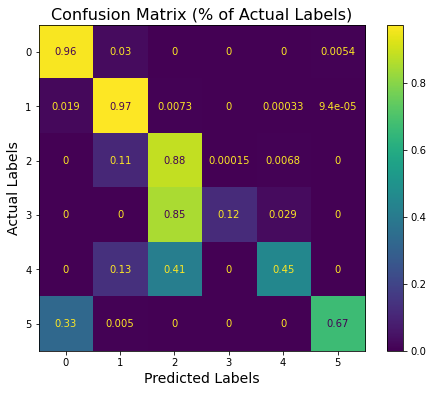

In [23]:
cv_score, oof_preds, holdout = score_newdata(catboost_pipeline)

new_rows.append((
    'CatBoost', cv_score, holdout,
     *recall_score(train['Cover_Type'], oof_preds, average = None)
))

# Summary

In [24]:
pd.DataFrame.from_records(
    data = new_rows,
    columns = ['model','cv_scores','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('cv_scores')

ValueError: 10 columns passed, passed data had 9 columns